<hr style="height:2px;">

# Demo: Neural network training for *BCM3D 2.0*

This notebook demonstrates training a CARE model for a 3D image transfer task, assuming that training data was already generated via (datagen.ipynb) and has been saved as the file ``training_data.npz``.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

The TensorFlow backend uses all available GPU memory by default, hence it can be useful to limit it:

In [2]:
# limit_gpu_memory(fraction=1/2)

<hr style="height:2px;">

# Training data

Load training data generated via datagen.ipynb, use 10% as validation data.

In [3]:
(X,Y), (X_val,Y_val), axes = load_training_data('/project/GahlmannLab/Yibo/cellDist/Code/TrainingDataGenerate/data/0107_training/training_data_0107.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 2304
number of validation images:	 256
image size (3D):		 (32, 64, 64)
axes:				 SZYXC
channels in / out:		 2 / 2


In [4]:
Y_val[:5].shape

(5, 32, 64, 64, 2)

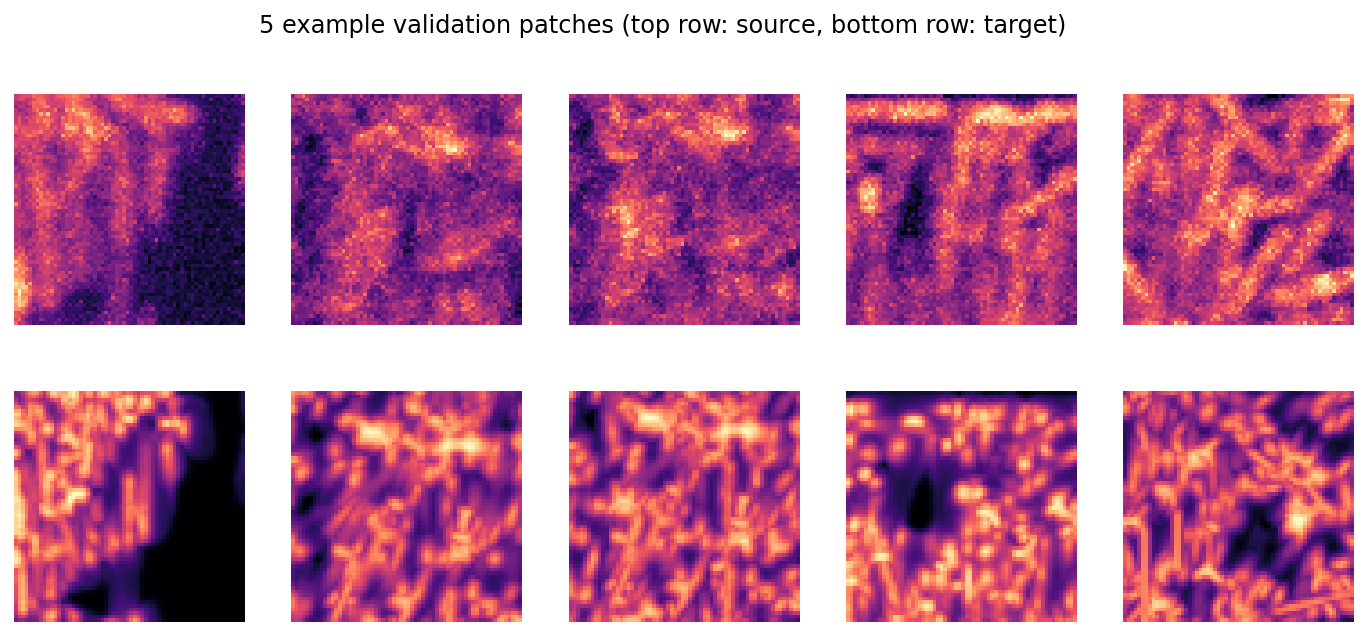

In [5]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5,:,:,:,1],Y_val[:5,:,:,:,1])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model

Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network,
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

In [6]:
config = Config(axes, n_channel_in, n_channel_out, 
                train_steps_per_epoch=100,
               unet_n_depth=3,
                unet_n_first=64
               )
print(config)
vars(config)

Config(n_dim=3, axes='ZYXC', n_channel_in=2, n_channel_out=2, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=True, unet_n_depth=3, unet_kern_size=3, unet_n_first=64, unet_last_activation='linear', unet_input_shape=(None, None, None, 2), train_loss='mae', train_epochs=100, train_steps_per_epoch=100, train_learning_rate=0.0004, train_batch_size=16, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0})


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 2,
 'n_channel_out': 2,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 2),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

We now create a CARE model with the chosen configuration (remember change model name and saved folder accordingly, we suggest put meaniful names for your models):

In [7]:
model = CARE(config, 'BCM3D2_08172022_0107TrainingData_depth3_first64', basedir='/project/GahlmannLab/Yibo/cellDist/Code/models')

2022-08-21 12:56:15.307203: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-21 12:56:17.500930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14616 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0


<hr style="height:2px;">

# Training

Training the model will likely take some time. We recommend to monitor the progress.

In [8]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f8c4a2cedc0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f8c4a2cedc0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals

2022-08-21 12:56:21.575183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


100/100 [==============================] - 124s 1s/step - loss: 0.1229 - mse: 0.0371 - mae: 0.1229 - val_loss: 0.1033 - val_mse: 0.0286 - val_mae: 0.1033 - lr: 4.0000e-04
Epoch 2/100
100/100 [==============================] - 103s 1s/step - loss: 0.0971 - mse: 0.0305 - mae: 0.0971 - val_loss: 0.0877 - val_mse: 0.0277 - val_mae: 0.0877 - lr: 4.0000e-04
Epoch 3/100
100/100 [==============================] - 103s 1s/step - loss: 0.0832 - mse: 0.0245 - mae: 0.0832 - val_loss: 0.0776 - val_mse: 0.0208 - val_mae: 0.0776 - lr: 4.0000e-04
Epoch 4/100
100/100 [==============================] - 102s 1s/step - loss: 0.0747 - mse: 0.0204 - mae: 0.0747 - val_loss: 0.0649 - val_mse: 0.0168 - val_mae: 0.0649 - lr: 4.0000e-04
Epoch 5/100
100/100 [==============================] - 102s 1s/step - loss: 0.0627 - mse: 0.0149 - mae: 0.0627 - val_loss: 0.0721 - val_mse: 0.0140 - val_mae: 0.0721 - lr: 4.0000e-04
Epoch 6/100
100/100 [==============================] - 103s 1s/step - loss: 0.0566 - mse: 0.0120 

Plot final training history (available in TensorBoard during training):

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


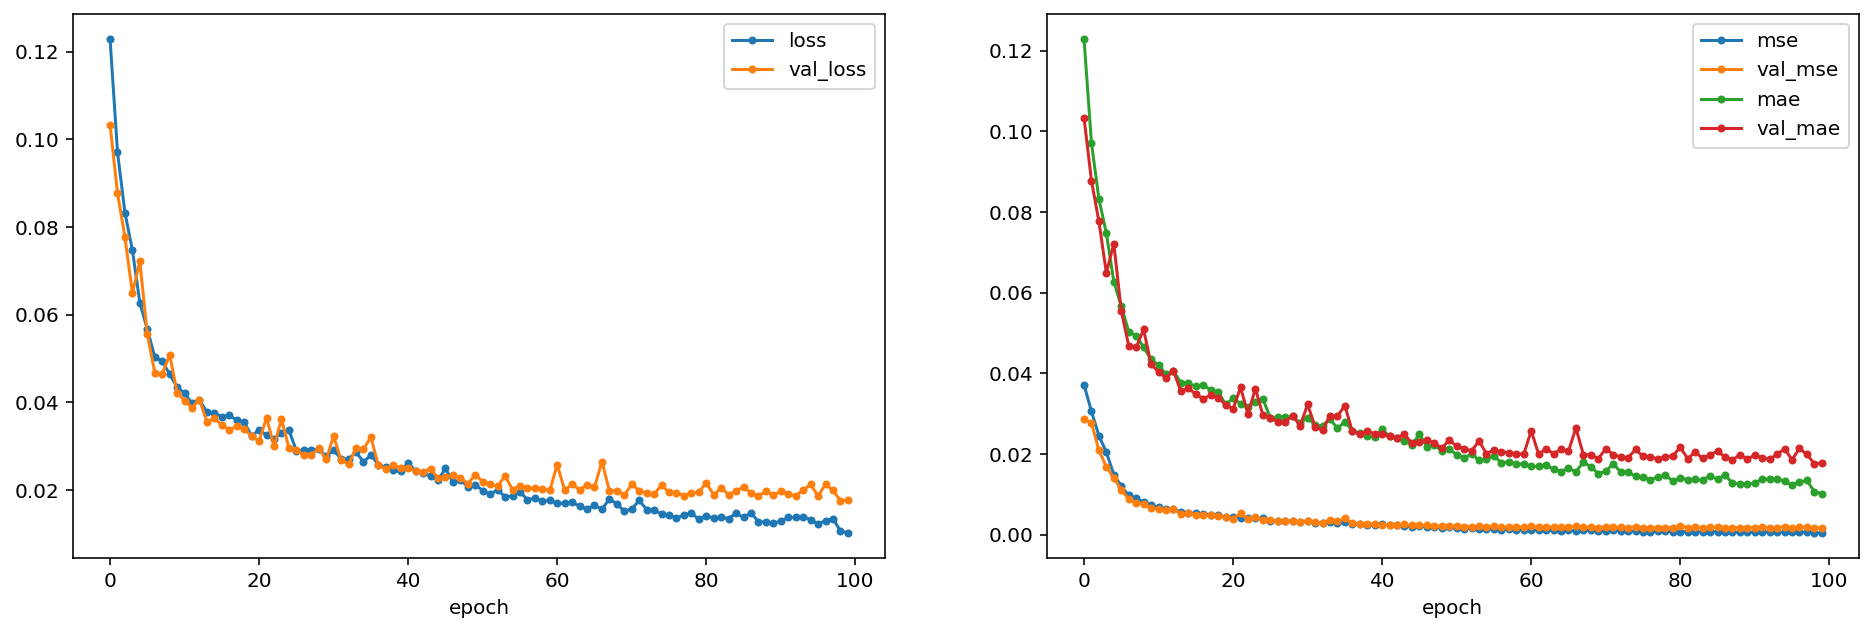

In [9]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


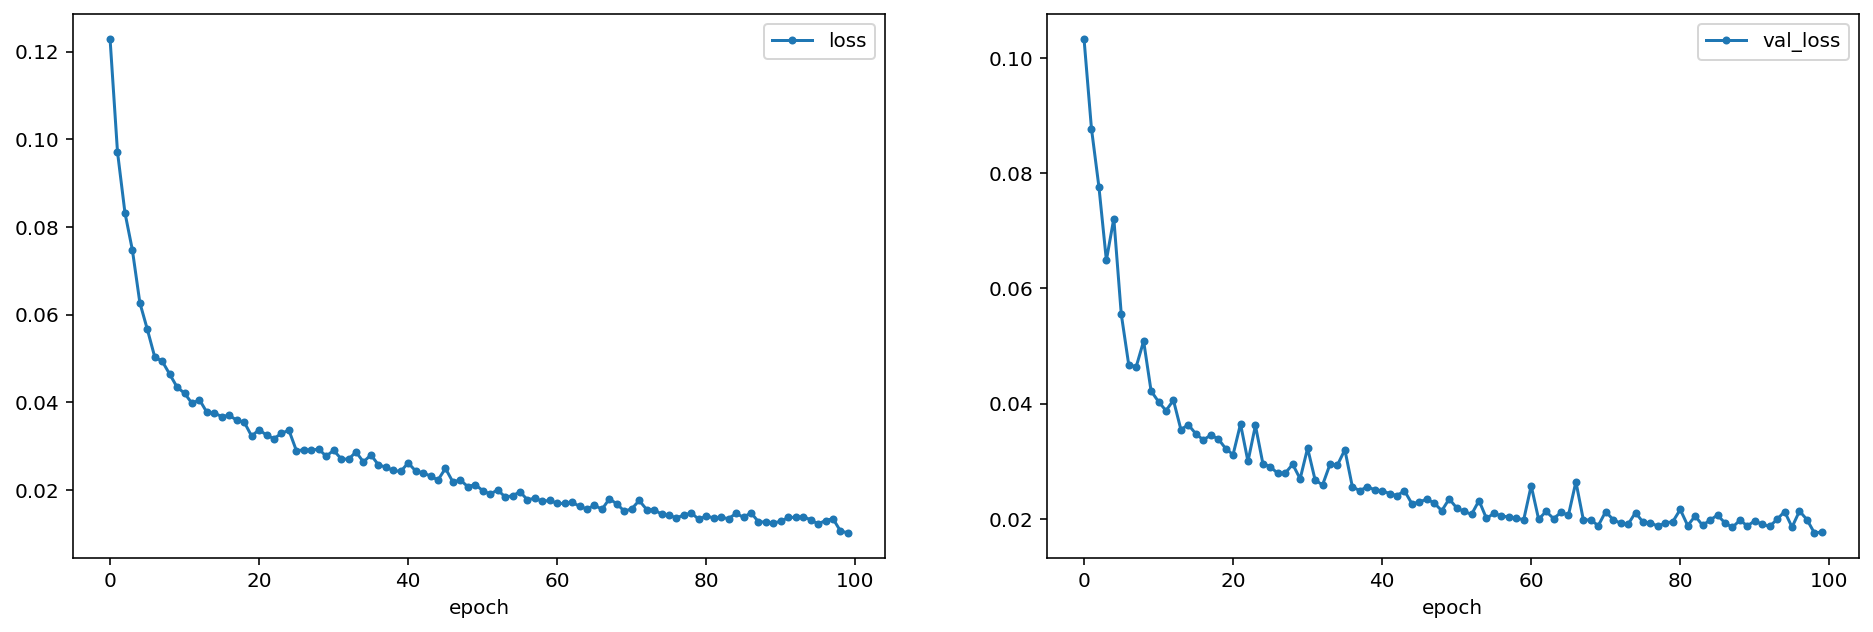

In [10]:
from six import string_types
keys = ['loss','val_loss']
plt.figure(figsize=(16,5))
w = len(keys)

plt.gcf()

for i, group in enumerate(keys):
    plt.subplot(1,w,i+1)
    for k in ([group] if isinstance(group,string_types) else group):
        plt.plot(history.epoch,history.history[k],'.-',label=k)
        
    plt.xlabel('epoch')
    plt.legend(loc='best')
# plt.tight_layout()
plt.savefig('/project/GahlmannLab/Yibo/cellDist/loss_3depth_first64_100epochs.eps', format='eps')

<hr style="height:2px;">

# Evaluation

Example results for validation images.

In [11]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
_P.shape

(5, 32, 64, 64, 2)

<Figure size 864x504 with 0 Axes>

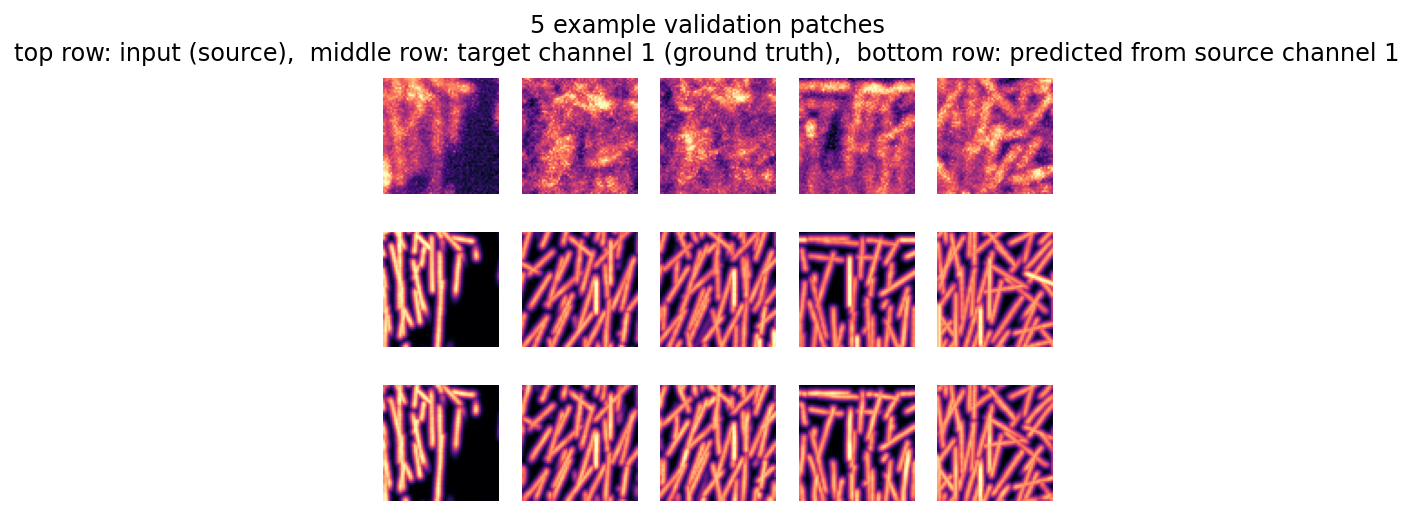

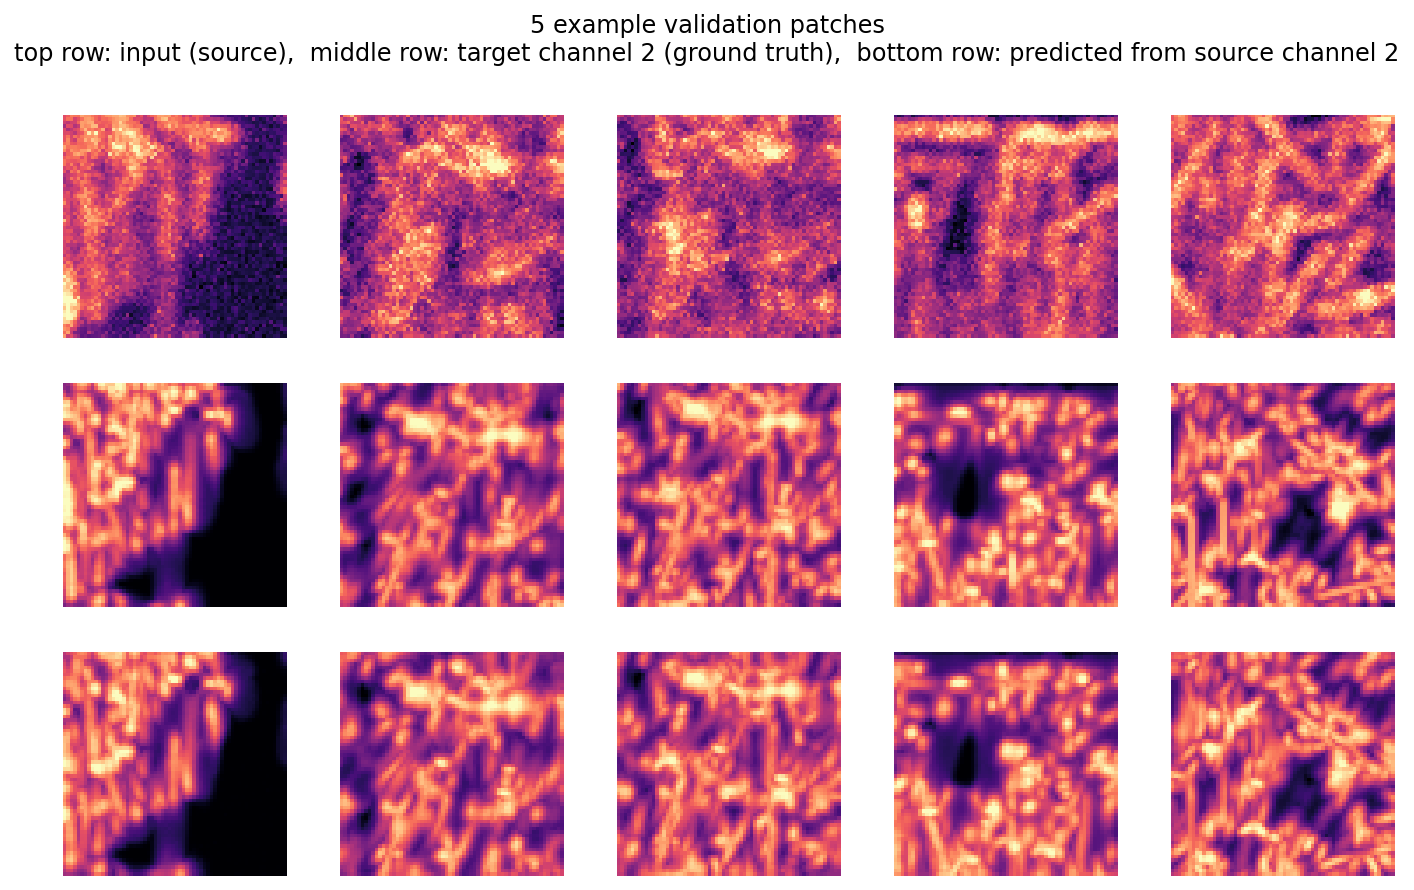

In [12]:
Y_val_show = Y_val[:5]
plot_some(X_val[:5,:,:,:,0],Y_val_show[:,:,:,:,0],_P[:,:,:,:,0],pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target channel 1 (ground truth),  '
             'bottom row: predicted from source channel 1');

plt.figure(figsize=(12,7))
plot_some(X_val[:5,:,:,:,0],Y_val_show[:,:,:,:,1],_P[:,:,:,:,1],pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target channel 2 (ground truth),  '
             'bottom row: predicted from source channel 2');